In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate, special

import default_function.calc_patm as calc_patm
import default_function.calc_kmm as calc_kmm
import default_function.calc_gammastar as calc_gammastar
import default_function.calc_ftemp_kphio as calc_ftemp_kphio
import default_function.calc_viscosity_h2o as calc_viscosity_h2o
import default_function.calc_density_h2o as calc_density_h2o 
#import default_function.calc_gs as calc_gs
#import default_function.calc_gsprime as calc_gsprime
#import default_function.rpmodel as rpmodel

In [34]:
# ---- 파라미터 정의 ----
par_plant_std = {
    # 'Ks0': 1e-12,           # m2
    # 'v_huber': 1e-4,        #
    # 'height': 10,           # m
    # 'conductivity_scalar': 3,
    'conductivity': 3e-17,
    'psi50': -2,            # MPa
    'b': 2
}

tc = 25
elev = 0
p = calc_patm.calc_patm(elev)
vpd = 1000 # unit = Pa

par_env_std = {
    'viscosity_water': calc_viscosity_h2o.calc_viscosity_h2o(tc, p),
    'density_water': calc_density_h2o.calc_density_h2o(tc, p),
    'patm': p,
    'tc': tc,
    'vpd': vpd
}

print("Plant parameters:", par_plant_std)
print("Environmental parameters:", par_env_std)


Plant parameters: {'conductivity': 3e-17, 'psi50': -2, 'b': 2}
Environmental parameters: {'viscosity_water': 0.0008900226790077092, 'density_water': 997.0470220770445, 'patm': 101325.0, 'tc': 25, 'vpd': 1000}


# Hydraulics

The key aspect of the flow of liquid water through the plant’s hydraulic pathways is that the conductivity of these pathways declines as water potential becomes more and more negative. This loss of conductivity is described by a vulnerability curve of the form:

물의 흐름에서 가장 중요한 점은, 식물체 내 수분 이동 경로(수리 경로)의 전도도(conductivity)가 수분 퍼텐셜(ψ, water potential)이 더 음의 값으로 낮아질수록 점점 감소한다는 것입니다.
즉, 식물에 가뭄 스트레스가 커질수록 물 이동이 어려워진다는 뜻입니다. 이러한 전도도 감소 현상은 아래와 같은 취약성 곡선(vulnerability curve)으로 수식화할 수 있습니다:


$$
P(\psi) = \left(\frac{1}{2}\right)^{\left( \frac{\psi}{\psi_{50}} \right)^b}
$$

- P(ψ): 해당 수분 퍼텐셜(ψ)에서의 상대적 수분 전도도 (0~1 사이)
- ψ: 수분 퍼텐셜(MPa, 보통 음수)
- ψ₅₀: 전도도가 50%로 감소하는 수분 퍼텐셜값 (음수)
- b: 곡선의 기울기(steepness)를 조절하는 파라미터

설명:
식물이 물을 빨아들이는 힘(ψ)이 강해질수록(더 음수로), 물관이 공기방울(embolism) 등으로 막히기 쉬워져서 수분 전도도가 감소합니다.
이 곡선은 식물의 가뭄 저항성, 수분 이동 한계 등을 이해하는 데 중요합니다.

| 파라미터        | 의미               | 실험 방법                            |
| ----------- | ---------------- | -------------------------------- |
| $\psi_{50}$ | 50% 도체율 손실 수분포텐셜 | 줄기/잎 수분포텐셜 vs 도체율 측정 후 피팅        |
| $b$         | 민감도 (기울기)        | 취약성 곡선의 경사 조절, Weibull 피팅 결과로 나옴 |

Tyree, M. T., & Sperry, J. S. (1989). Vulnerability of xylem to cavitation and embolism.
→ 이 개념을 처음 소개한 고전 논문

Choat et al. (2012). Global convergence in the vulnerability of forests to drought.
→ 다양한 식물 종에 대한 ψ₅₀ 데이터 정리

Gleason et al. (2016). Weak tradeoff between xylem safety and hydraulic efficiency.
→ b 값과 도체율 사이의 관계 분석


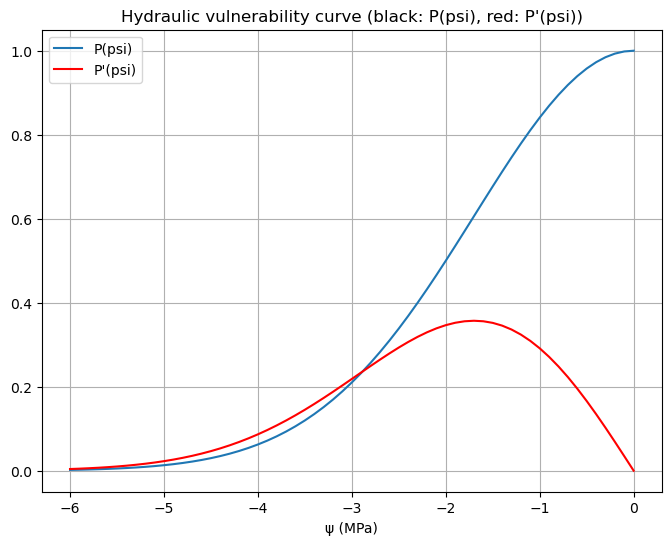

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from default_function.hyd_vulnerability_curve import P, Pprime, Pprimeprime

# 파라미터 (예시), 작물에 따라서 다름
psi50 = -2
b = 2

# psi 값 범위
psi = np.arange(-6, 0.05, 0.1)

# 계산
df = pd.DataFrame({
    "psi": psi,
    "P": P(psi, psi50, b),
    "Pprime": Pprime(psi, psi50, b),
    "Pprimeprime": Pprimeprime(psi, psi50, b)
})

# 플롯
plt.figure(figsize=(8, 6))
plt.plot(df["psi"], df["P"], label="P(psi)")
plt.plot(df["psi"], df["Pprime"], color="red", label="P'(psi)")
plt.title("Hydraulic vulnerability curve (black: P(psi), red: P'(psi))")
plt.xlabel("ψ (MPa)")
plt.legend()
plt.grid(True)
plt.show()

2차 미분은 함수의 곡률(curvature), 즉 "얼마나 급격하게 꺾이는지"를 나타냅니다.

이 값은 취약성 곡선의 inflection point(변곡점) 위치, 또는 곡선의 민감도 분석 등에서 유용하게 사용됩니다.

예를 들어, 곡선이 급격하게 꺾이는 위치(=수분 스트레스에 가장 민감하게 반응하는 구간)를 찾거나,

모델에서 최적화 또는 민감도 분석을 할 때 중요합니다.

시각적으로 예시
P(ψ) 곡선은 S-자 형태입니다.

P'(ψ)는 해당 곡선의 기울기(어느 지점에서 가장 급격하게 변화하는지)

P''(ψ)는 곡률, 즉 "곡선이 얼마나 급하게/천천히 바뀌는지"를 알려줍니다.



## 줄기와 잎에서의 물 흐름 (Water flow in the stem and in the leaf)

### 1. 식물의 일반적인 수분 이동 방정식

식물 내 어느 도체 경로를 통과하는 물의 흐름(수분 플럭스)은 다음 미분 방정식을 따릅니다.

$$
\frac{d\psi}{dh} = -\rho g - \frac{\eta Q}{K(h)\,P(\psi, h)}
$$

- $\psi$: 수분포텐셜 (MPa)
- $h$: 기준점으로부터의 거리 (m)
- $\rho$: 물의 밀도 ($\mathrm{kg\,m^{-3}}$)
- $g$: 중력 가속도 ($\mathrm{m\,s^{-2}}$)
- $\eta$: 물의 점도 ($\mathrm{Pa\,s}$)
- $Q$: 수분 플럭스 (흐름 속도) ($\mathrm{kg\,m^{-2}\,s^{-1}}$)
- $K(h)$: 위치 $h$에서의 도체율 ($\mathrm{kg\,m^{-1}\,s^{-1}\,MPa^{-1}}$)
- $P(\psi, h)$: 취약성 곡선(vulnerability curve), $h$에서의 수분포텐셜 $\psi$에 따른 상대 도체율(무차원)

> $K$와 $P$는 구조적 변화(예: 도관의 기하학, 길이 변화 등)로 인해 $h$에 따라 달라질 수 있습니다.

---

### 2. 줄기(도관) 내 물 흐름

줄기 내 연결된 도관을 통한 물의 흐름은 **Hagen-Poiseuille 식**을 따릅니다.

- 개별 도관의 도체율:
  $$
  K_v = \frac{\pi r_v^4}{8 l_v}
  $$
  - $K_v$: 개별 도관의 도체율 ($\mathrm{m^4}$)
  - $r_v$: 도관 반지름 ($\mathrm{m}$)
  - $l_v$: 도관 길이 ($\mathrm{m}$)

- 도관이 병렬 연결된 경우(단위 면적당 $\rho_v$개의 도관):
  $$
  K_s = \frac{\pi \rho_v r_v^4}{8}
  $$
  - $K_s$: 단위 면적당 줄기 도체율 ($\mathrm{m^2}$)
  - $\rho_v$: 단위 면적당 도관 밀도 ($\mathrm{m^{-2}}$)

- 실제 관찰값 예시 (Choat et al. 2005):
  - $\rho_v = 217\,\mathrm{mm^{-2}}$
  - $r_v = 15.25\,\mu\mathrm{m}$
  - $\Rightarrow K_s = 4.6 \times 10^{-12} \ \mathrm{m^2}$ (이론값)
  - 실제는 4배 정도 낮아 $K_{s,actual} = 1.15 \times 10^{-12} = 1.29\,\mathrm{kg\,m^{-1}\,s^{-1}\,MPa^{-1}}$

- 중력 및 도관 테이퍼링 효과를 무시할 경우, 줄기에서의 $Q$는 다음과 같이 쓸 수 있습니다:
  $$
  Q = -\frac{K_s \nu_H}{H \eta} \int_{\psi_p}^{\psi_s} P_s(\psi)\, d\psi
  $$

  - $\nu_H$: Huber value (줄기 단면적 대비 잎면적의 비, 무차원)
  - $H$: 식물 높이 ($\mathrm{m}$)
  - $\psi_s$: 토양에서의 수분포텐셜 (MPa)
  - $\psi_p$: 잎자루 끝(도관 말단)에서의 수분포텐셜 (MPa)
  - $P_s(\psi)$: 줄기 취약성 곡선

  > $Q$는 단위 잎면적당 물 플럭스이므로, 줄기 도체율에 Huber value를 곱해 leaf-specific conductivity로 환산합니다.

---

### 3. 도관 외부(잎) 경로의 물 흐름

잎에서 도관을 벗어난 뒤, 물은 bundle sheath cell과 여러 해면조직 세포벽을 거쳐 증산하게 됩니다.  
이 **도관 외부 경로(잎)는 저항이 매우 크며**, 전도도도 줄기에 비해 훨씬 더 빨리 감소하므로 잎이 hydraulic bottleneck(병목)이 됩니다.

이 경로 전체를 하나의 등가 경로로 나타내면:

$$
Q = -\frac{K_l \Delta L}{\eta} \int_{\psi_l}^{\psi_p} P(\psi)\, d\psi
$$

- $K_l$: 잎의 단위면적 도체율 ($\mathrm{kg\,m^{-1}\,s^{-1}\,MPa^{-1}}$)
- $\Delta L$: 도관 외부 경로의 길이 ($\mathrm{m}$)
- $\psi_l$: 잎 끝(증산 직전)의 수분포텐셜 (MPa)

> $\Delta L$은 잎 두께, vein length per area (VLA) 등에 따라 결정됩니다.

---

### 4. 수분 밸런스 (Water Balance)

식물 내 수분 저장(용량) 효과를 무시하면, 수분 이동속도 $Q$는 증산속도 $E$와 같아야 합니다.

$$
Q = 1.6\,g_s D
$$

- $g_s$: 기공전도도 ($\mathrm{mol\,m^{-2}\,s^{-1}}$)
- $D$: 증기압 차이 (VPD, $\mathrm{mol\,mol^{-1}}$)

이를 통합하면,

$$
Q = -\frac{K_s \nu_H}{H \eta} \int_{\psi_p}^{\psi_s} P_s(\psi)\, d\psi = -\frac{K_l \Delta L}{\eta} \int_{\psi_l}^{\psi_p} P(\psi)\, d\psi = 1.6 g_s D
$$

---

### 5. 잎이 병목인 경우의 단순화

최근 연구에 따르면 잎이 주된 병목구간(hydraulic bottleneck)임이 밝혀지고 있습니다.  
- $K_s \gg K_l$ (줄기보다 잎의 도체율이 매우 낮다)
- 줄기에서의 수분포텐셜 강하 $\Delta \psi_s \ll \Delta \psi$
- 줄기의 취약성 곡선 $P_s(\psi) \approx 1$ (즉, 거의 전체 구간에서 도체율 유지)
- $\psi_p \approx \psi_s$

따라서 최종적으로,

$$
g_s = - \frac{K_l}{1.6 D \eta} \int_{\psi_s - \Delta \psi}^{\psi_s} P(\psi)\, d\psi
$$

- $\Delta \psi$: 잎 내 도관 외부 경로에서의 수분포텐셜 강하 (MPa)

> 이때 $g_s$는 $\chi$ (공기 중 CO₂ 농도분율)와 무관하게 $ \Delta \psi $로부터 해석적으로 구할 수 있습니다.


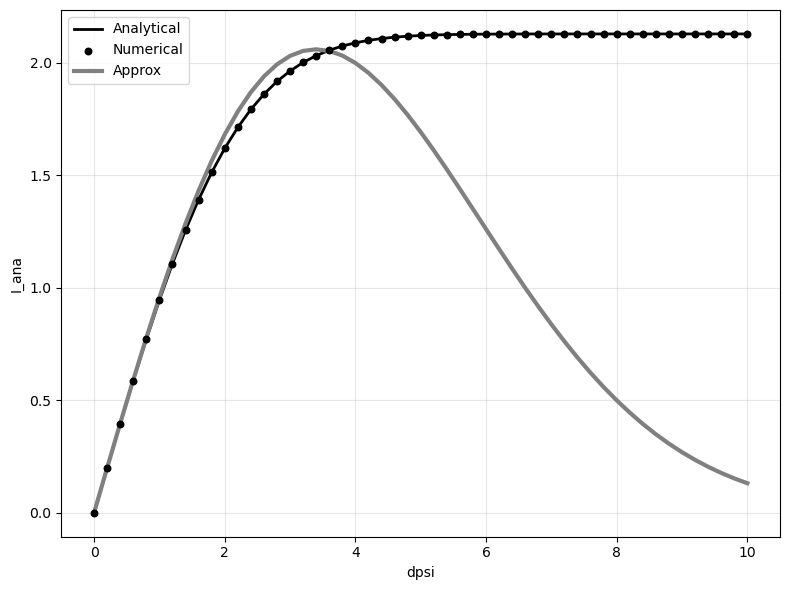

In [36]:
import default_function.hyd_transpiration as hyd_transpiration

calc_gsprime = hyd_transpiration.calc_gsprime
integral_P = hyd_transpiration.integral_P

integral_P_ana = hyd_transpiration.integral_P_ana
integral_P_num = hyd_transpiration.integral_P_num
integral_P_approx = hyd_transpiration.integral_P_approx

dpsi_vals = np.arange(0, 10.01, 0.2)
I_ana = [-integral_P_ana(dpsi, 0, -2, 2) for dpsi in dpsi_vals]
I_num = [-integral_P_num(dpsi, 0, -2, 2) for dpsi in dpsi_vals]
I_approx = [-integral_P_approx(dpsi, 0, -2, 2) for dpsi in dpsi_vals]

plt.figure(figsize=(8,6))
plt.plot(dpsi_vals, I_ana, color="black", lw=2, label="Analytical")
plt.scatter(dpsi_vals, I_num, color="black", s=22, label="Numerical", zorder=10)
plt.plot(dpsi_vals, I_approx, color="grey", lw=3, label="Approx")

plt.xlabel("dpsi")
plt.ylabel("I_ana")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

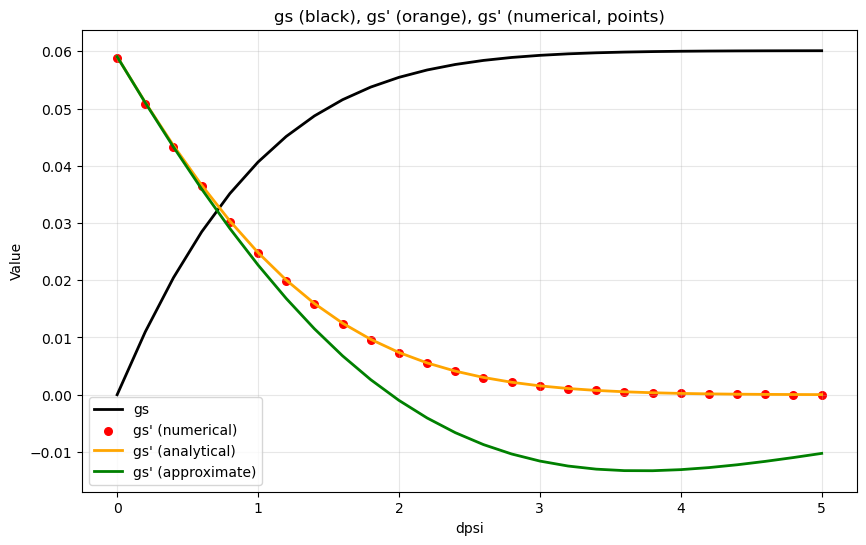

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 테스트를 위한 psi_soil 값 설정
ps = -2.0

# dpsi 범위 생성
dpsi_range = np.arange(0, 5.1, 0.2)  # 0에서 5까지 0.2 간격

# 각 함수의 결과값 계산
gs_values = []
gsprime_num_values = []
gsprime_analytical_values = []
gsprime_approx_values = []

for dpsi in dpsi_range:
    try:
        # gs 계산
        gs = hyd_transpiration.calc_gs(dpsi, ps, par_plant_std, par_env_std)
        gs_values.append(gs)
        
        # numerical derivative
        gsprime_num = hyd_transpiration.calc_gsprime_numerical(dpsi, ps, par_plant_std, par_env_std)
        gsprime_num_values.append(gsprime_num)
        
        # analytical derivative
        gsprime = calc_gsprime(dpsi, ps, par_plant_std, par_env_std)
        gsprime_analytical_values.append(gsprime)
        
        # approximate derivative
        gsprime_approx = hyd_transpiration.calc_gsprime_approx(dpsi, ps, par_plant_std, par_env_std)
        gsprime_approx_values.append(gsprime_approx)
        
    except Exception as e:
        print(f"Error at dpsi={dpsi}: {e}")
        gs_values.append(np.nan)
        gsprime_num_values.append(np.nan)
        gsprime_analytical_values.append(np.nan)
        gsprime_approx_values.append(np.nan)


plt.figure(figsize=(10, 6)) 
plt.plot(dpsi_range, gs_values, 'k-', label='gs', linewidth=2) # gs (black line)
plt.scatter(dpsi_range, gsprime_num_values, color='red', label="gs' (numerical)", s=30) # gsprime numerical (red points)
plt.plot(dpsi_range, gsprime_analytical_values, color='orange', label="gs' (analytical)", linewidth=2) # gsprime analytical (orange line)
plt.plot(dpsi_range, gsprime_approx_values, color='green', label="gs' (approximate)", linewidth=2) # gsprime approximate (green line)
plt.title("gs (black), gs' (orange), gs' (numerical, points)", fontsize=12)
plt.xlabel('dpsi')
plt.ylabel('Value')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 광합성 (Photosynthesis)

### 탄소 고정 속도 (Rates of Carbon Fixation)

광합성 속도는 **전자전달 제한**과 **카복실화 제한** 속도 중 작은 값에 의해 결정됩니다.

#### 1. 카복실화 제한 광합성 속도 (Cowan-Farquhar 모델)

$$
A_c = V_{c\max} \frac{c_i - \Gamma^*}{c_i + K} - R_d
$$

여기서  
- $A_c$: 카복실화 제한 동화속도  
- $V_{c\max}$: Rubisco의 최대 카복실화 효소 활성  
- $c_i$: 세포내 $CO_2$ 농도  
- $\Gamma^*$: $CO_2$ 보상점  
- $K$: Michaelis-Menten 상수  
- $R_d$: 암호흡

$R_d$는 보통 $V_{c\max}$의 비례값($\delta$)로 가정합니다.

$$
R_d = \delta V_{c\max}
$$

따라서 식은 다음과 같이 정리됩니다.

$$
A_c = V_{c\max} \frac{c_i (1-\delta) - (\Gamma^* + \delta K)}{c_i + K}
$$

---

#### 2. 전자전달 제한 광합성 속도

전자전달 제한 시 동화속도는 다음과 같습니다.

$$
A_j = A_{Jm} \frac{c_i - \Gamma^*}{c_i + 2\Gamma^*} - R_d
$$

여기서

- $A_{Jm}$: 유효 광합성 전자전달 최대속도  
- $J_{max}$: 최대 전자전달속도  
- $\phi_0$: 양자수율 (quantum yield)  
- $I_{abs}$: 잎이 흡수한 광량

$A_{Jm}$는 다음과 같이 계산합니다.

$$
A_{Jm} = \frac{\phi_0 I_{abs}}{\sqrt{1 + \left(\frac{4 \phi_0 I_{abs}}{J_{max}}\right)^2}}
$$

---

#### 3. $CO_2$ 동화와 기공전도도의 연계

$CO_2$의 순 동화속도는 다음과 같습니다.

$$
A = g_s c_a (1 - \chi)
$$

- $g_s$: 기공전도도  
- $c_a$: 대기 중 $CO_2$ 농도  
- $\chi$: 기공내/대기 $CO_2$ 비율

---

### 조정 가설 (Coordination Hypothesis)

조정 가설에 따르면, $V_{c\max}$는 잎의 전자전달 능력을 완전히 활용하도록(과도하지 않게) 조절된다고 가정합니다.  
즉, 주어진 환경 조건(빛, 수분 등)에서  
**카복실화 제한 속도**와 **전자전달 제한 속도**가 일치하도록 $V_{c\max}$가 조정됩니다.

$$
A = A_c = A_j
$$

따라서

$$
V_{c\max} \frac{c_i - \Gamma^*}{c_i + K} - R_d = A_{Jm} \frac{c_i - \Gamma^*}{c_i + 2\Gamma^*} - R_d
$$

즉,

$$
V_{c\max} = A_{Jm} \frac{c_i + K}{c_i + 2\Gamma^*}
$$

---

#### 4. $A_j$를 $\chi$와 $g_s$로 표현

위의 연립방정식에서 $A_j$는 아래와 같이 쓸 수 있습니다.

$$
A_j = g_s c_a (1 - \chi) = \frac{A_{Jm} \left[c_i (1-\delta) - (\Gamma^* + \delta K)\right]}{c_i + 2\Gamma^*}
$$

따라서 $A_{Jm}$는 다음과 같이 $\chi$로 표현할 수 있습니다.

$$
A_{Jm} = \frac{g_s c_a (1-\chi)(\chi c_a + 2\Gamma^*)}{\chi c_a (1-\delta) - (\Gamma^* + \delta K)}
$$

---

### Rubisco 제한 동화속도($A_c$)에서 $c_i$ 계산

만약 $g_s$, $V_{c\max}$ 등 광합성 능력이 주어졌을 때 $c_i$와 $A$를 구하려면 다음의 2차 방정식을 풉니다.

$$
A = g_s (c_a - c_i) = V_{c\max} \frac{c_i (1-\delta) - (\Gamma^* + \delta K)}{c_i + K}
$$

이를 전개하면,

$$
-g_s c_i^2 + (g_s c_a - g_s K - V_{c\max}(1-\delta)) c_i + (g_s c_a K + V_{c\max} (\Gamma^* + \delta K)) = 0
$$

---

### 전자전달 제한 동화속도($A_j$)에서 $c_i$ 계산

이 경우도 마찬가지로 2차방정식을 풉니다.

$$
A = g_s (c_a - c_i) = A_{Jm} \frac{c_i (1-\delta) - (\Gamma^* + \delta K)}{c_i + 2\Gamma^*}
$$

이를 전개하면,

$$
-g_s c_i^2 + (g_s c_a - 2g_s \Gamma^* - A_{Jm}(1-\delta)) c_i + (2g_s c_a \Gamma^* + A_{Jm} (\Gamma^* + \delta K)) = 0
$$

---

위 식들은 실제 모형 구현이나 광합성 데이터 분석시 $A$, $c_i$, $g_s$ 등을 유기적으로 계산하는 데 사용됩니다.


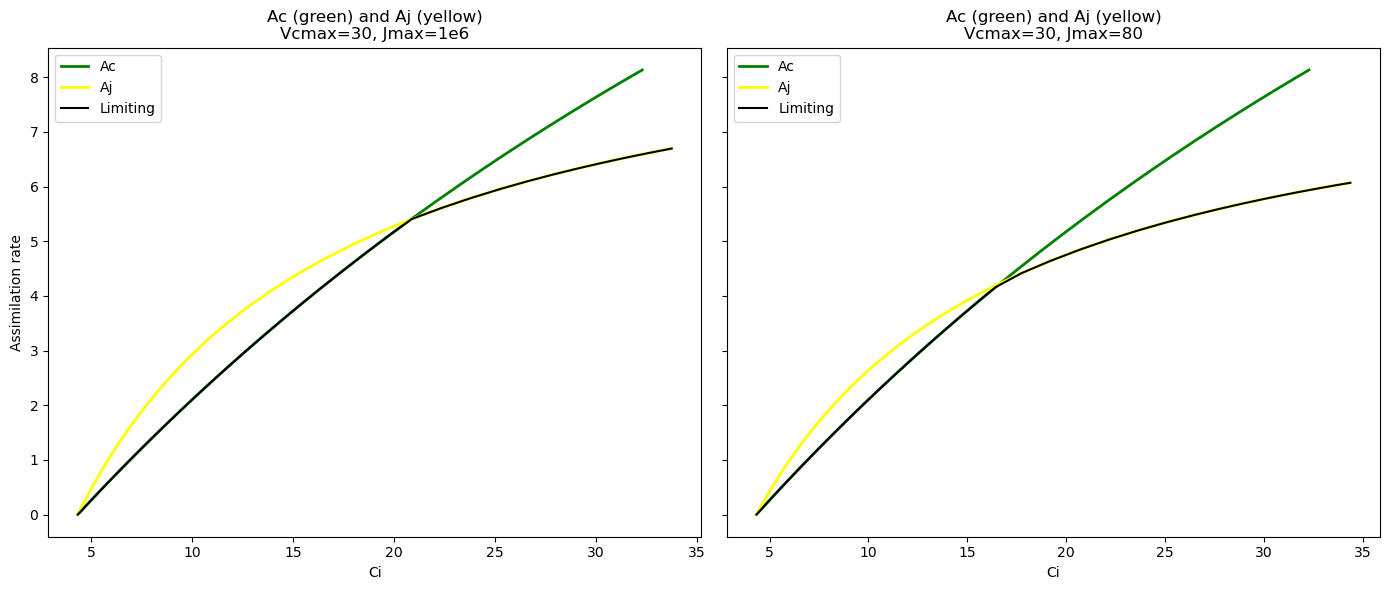

In [38]:
import default_function.hyd_photosynthesis as hyd_photosynthesis

def get_std_photosynthesis_params():
    kphio = 0.05
    tc = 25
    ppfd = 400
    co2 = 400
    elv = 0
    fapar = 0.7
    p = calc_patm.calc_patm(elv)
    return {
        "kmm": calc_kmm.calc_kmm(tc, p),
        "gammastar": calc_gammastar.calc_gammastar(tc, p),
        "phi0": kphio * calc_ftemp_kphio.calc_ftemp_kphio(tc),
        "Iabs": ppfd * fapar,
        "ca": co2 * p * 1e-6,
        "patm": p,
        "delta": 0.0
    }

# gs (기공 전도도) 배열 생성
gs_vals = np.exp(np.linspace(np.log(0.000001), np.log(.1), 100))
par_photosynth = get_std_photosynthesis_params()

# 1. Jmax = 1e6
aj1 = [hyd_photosynthesis.calc_assim_light_limited(gs, 1e6, par_photosynth) for gs in gs_vals]
ac1 = [hyd_photosynthesis.calc_assim_rubisco_limited(gs, 30, par_photosynth) for gs in gs_vals]
alim1 = [hyd_photosynthesis.calc_assimilation_limiting(30, 1e6, gs, par_photosynth) for gs in gs_vals]

# 2. Jmax = 80
aj2 = [hyd_photosynthesis.calc_assim_light_limited(gs, 80, par_photosynth) for gs in gs_vals]
ac2 = [hyd_photosynthesis.calc_assim_rubisco_limited(gs, 30, par_photosynth) for gs in gs_vals]
alim2 = [hyd_photosynthesis.calc_assimilation_limiting(30, 80, gs, par_photosynth) for gs in gs_vals]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 첫 번째 플롯 (Jmax = 1e6)
axes[0].plot([a["ci"] for a in ac1], [a["a"] for a in ac1], color='green', lw=2, label='Ac')
axes[0].plot([a["ci"] for a in aj1], [a["a"] for a in aj1], color='yellow', lw=2, label='Aj')
axes[0].plot([a["ci"] for a in alim1], [a["a"] for a in alim1], color='black', lw=1.5, label='Limiting')
axes[0].set_title("Ac (green) and Aj (yellow)\nVcmax=30, Jmax=1e6")
axes[0].set_xlabel("Ci")
axes[0].set_ylabel("Assimilation rate")
axes[0].legend()

# 두 번째 플롯 (Jmax = 80)
axes[1].plot([a["ci"] for a in ac2], [a["a"] for a in ac2], color='green', lw=2, label='Ac')
axes[1].plot([a["ci"] for a in aj2], [a["a"] for a in aj2], color='yellow', lw=2, label='Aj')
axes[1].plot([a["ci"] for a in alim2], [a["a"] for a in alim2], color='black', lw=1.5, label='Limiting')
axes[1].set_title("Ac (green) and Aj (yellow)\nVcmax=30, Jmax=80")
axes[1].set_xlabel("Ci")
axes[1].legend()

plt.tight_layout()
plt.show()


## 광합성의 비용(Costs associated with photosynthesis)

식물이 일정한 광합성 속도를 유지하기 위해서는, 광합성 기구와 수분 수송 경로(hydraulic pathway)를 유지하는 데 에너지를 소모해야 합니다.

광합성 기구에는 카르복실화 능력(루비스코 양)과 전자전달 능력(RuBP 재생 속도)이 포함되며, 두 능력은 서로 조정되어 있기 때문에 이 비용은 $J_{\text{max}}$에 비례한다고 가정합니다.

수분 수송 경로를 유지하는 비용에는  
1) 수송로 자체의 구축 및 호흡 비용,  
2) 줄기와 잎에서 수분 퍼텐셜 구배를 유지하는 비용(도관 손상복구 등),  
3) 수리적 실패(hydraulic failure, cavitation 등)의 잠재적 위험비용  
이 포함됩니다. 이들 비용을 기계론적으로 도출할 수도 있지만, $\Delta\psi^2$ 꼴로 단순하게 표현하는 것이 토양 수분에 대한 다양한 반응 양상과 잘 들어맞았습니다.  

물이 풍부한 경우 $\Delta\psi$는 증산(transpiration)에 비례하고,  
물이 부족한 경우 $\Delta\psi$가 커질수록 수리적 손상이 커져 더 높은 비용이 발생합니다.

다수의 기존 기공 최적화 모델에서는 수리적 비용과 수분 이용 비용을 별도로 다룹니다.  
여기서는 데이터 한계로 두 비용을 구분하지 않고, $\Delta\psi^2$가 이 두 비용을 모두 대변한다고 봅니다.

---

## 기공 최적화 프레임워크(Stomatal Optimization Framework)

식물은 다음의 이익(목적함수) $F$를 **최대화**한다고 가정합니다.

$$
F = A_j - \alpha J_{\text{max}} - \gamma \Delta\psi^2
$$

여기서 각 항은 두 독립 변수 $\chi$ (잎 내부 $CO_2$ 비율), $\Delta\psi$ (잎-토양 수분 퍼텐셜 차)의 함수입니다.

$A=g_s(c_a - c_i)$
에서 기공을 통한 이산화탄소 확산량은 광합성량이므로 $c_i$ 를 $\chi c_a$로 치환하면

$$
F = g_s c_a (1 - \chi) - \alpha J_{\text{max}} - \gamma \Delta\psi^2
$$



이익 함수의 최적 조건은, 그라디언트(편미분)가 0이 되는 지점에서 찾습니다.

$$
\frac{\partial F}{\partial \chi} = -g_s c_a - \alpha \frac{\partial J_{\text{max}}}{\partial A_{Jm}} \frac{\partial A_{Jm}}{\partial \chi} = 0
$$

$$
\frac{\partial F}{\partial \Delta\psi} = \frac{\partial g_s}{\partial \Delta\psi} c_a (1 - \chi) - \alpha \frac{\partial J_{\text{max}}}{\partial A_{Jm}} \frac{\partial A_{Jm}}{\partial \Delta\psi} - 2\gamma\Delta\psi = 0
$$

위 식에 필요한 네 가지 미분항은 다음과 같습니다.

$$
\frac{\partial J_{\text{max}}}{\partial A_{Jm}} = \frac{4(\phi_0 I_{\text{abs}})^3}{\left[(\phi_0 I_{\text{abs}})^2 - A_{Jm}^2\right]^{3/2}}
$$

$$
\frac{\partial A_{Jm}}{\partial \chi} = g_s c_a \left( 
\frac{ \delta^2 \Gamma^* c_a (K c_a + 1) + K c_a (2\chi - 1) + \chi^2 (\delta(Kc_a + \chi) + \Gamma^*c_a - \chi)^2 - (\chi - \Gamma^*c_a)^2 + 3\Gamma^* c_a (1 - \Gamma^*c_a)(\delta(Kc_a + \chi) + \Gamma^*c_a - \chi)^2 }{ \left[\chi c_a(1 - \delta) - (\Gamma^* + \delta K)\right]^2 }
\right)
$$

$$
\frac{\partial A_{Jm}}{\partial \Delta\psi} = \frac{\partial g_s}{\partial \Delta\psi} c_a (1 - \chi) \frac{(\chi c_a + 2\Gamma^*)}{\chi c_a (1-\delta) - (\Gamma^* + \delta K)}
$$

$$
\frac{\partial g_s}{\partial \Delta\psi} = \frac{\partial}{\partial \Delta\psi} \left( -\frac{K_L}{1.6 D} \int_{\psi_s - \Delta\psi}^{\psi_s} P(\psi) d\psi \right ) = \frac{K_L}{1.6 D} P(\psi_s - \Delta\psi)
$$

이 네 가지 도함수를 대입하면, 이익 함수의 최적점(그라디언트=0)을 **수치적으로 계산**할 수 있습니다.

---

## 강한 $J_{\text{max}}$ 제한(Strong $J_{\text{max}}$ limitation)일 때 해석적 해

$J_{\text{max}} \ll 4\phi_0 I_{\text{abs}}$ (즉, $4A_{Jm} \approx J_{\text{max}}$)인 특별한 경우에는  
최적 $\chi$에 대한 **해석적(명시적) 해**가 존재합니다.

$$
\frac{\partial J_{\text{max}}}{\partial A_{Jm}} = 4
$$

따라서,

$$
\frac{\partial F}{\partial \chi} = -g_s c_a - 4\alpha \frac{\partial A_{Jm}}{\partial \chi} = 0
$$

이것은 $\chi$에 대한 2차방정식이 되어,

$$
\chi^* = 
\frac{(1-4\alpha-\delta)(\delta k + \Gamma^* c_a) + 4\alpha(1-4\alpha-\delta)(3\Gamma^* c_a - \delta(2\Gamma^*c_a + k)) (1-\Gamma^* c_a - \delta(1 + k))^{1/2}}
{(1-\delta)(1-4\alpha-\delta)}
$$

만약 암호흡($\delta=0$)이 없을 경우에는 다음처럼 단순화됩니다.

$$
\chi^* = 
\frac{\Gamma^* c_a (1-4\alpha) + \sqrt{12\alpha(1-4\alpha)\Gamma^*c_a(1-\Gamma^*c_a)}}{1 - 4\alpha}
$$


## Analytical solution
### Prorotype plant parameters


In [39]:
# PM plant parameter set (proto_pm)
par_plant_proto_pm = {
    # "Ks0": 1e-12,          # Xylem permeability (m2)
    # "v_huber": 1e-4,       # Huber value (sapwood/leaf area ratio)
    # "conductivity_scalar": 3, 
    # "height": 10,          # Plant height (m)
    "conductivity": 3e-17,   # 전체 leaf specific conductivity (m2)
    "psi50": -2,             # Vulnerability curve (MPa)
    "b": 2                   # Curve shape parameter
}

# LC plant parameter set (proto_lc)
par_plant_proto_lc = {
    # "Ks0": 1e-12,
    # "v_huber": 1e-4,
    # "conductivity_scalar": 0.8,
    # "height": 10,
    "conductivity": 8e-17,   # 전체 leaf specific conductivity (m2)
    "psi50": -2,
    "b": 2
}


The analytical solution is obtained by solving the above system of equations.

In [40]:
from scipy.optimize import root_scalar
from scipy.special import gammainc, gamma

# --- 전제: P, Pprime, Pprimeprime, calc_gs, calc_gsprime 등 기존 함수는 이미 정의되어 있어야 함 ---

def calc_Aj_max(gs, x, par_photosynth):
    g = par_photosynth['gammastar'] / par_photosynth['ca']
    k = par_photosynth['kmm'] / par_photosynth['ca']
    ca = par_photosynth['ca'] / par_photosynth['patm'] * 1e6
    d = par_photosynth['delta']
    return gs * ca * (1 - x) * (x + 2 * g) / (x * (1 - d) - (g + d * k))

def calc_jmax_from_Ajmax(ajmax, par_photosynth):
    p = par_photosynth['phi0'] * par_photosynth['Iabs']
    return 4 * p / ( (p / ajmax) ** 2 - 1 ) ** 0.5

def calc_djmax_dAjmax(ajmax, par_photosynth):
    p = par_photosynth['phi0'] * par_photosynth['Iabs']
    return 4 * p**3 / ajmax**3 / ( (p / ajmax) ** 2 - 1 ) ** (3/2)

def calc_dAjmax_dchi(gs, x, par_photosynth):
    g = par_photosynth['gammastar'] / par_photosynth['ca']
    k = par_photosynth['kmm'] / par_photosynth['ca']
    ca = par_photosynth['ca'] / par_photosynth['patm'] * 1e6
    d = par_photosynth['delta']
    numerator = d*(2*g*(k+1) + k*(2*x-1) + x**2) - ((x-g)**2 + 3*g*(1-g))
    denominator = (d*(k+x) + g - x) ** 2
    return gs * ca * numerator / denominator

def calc_dAjmax_ddpsi(gsprime, x, par_photosynth):
    g = par_photosynth['gammastar'] / par_photosynth['ca']
    k = par_photosynth['kmm'] / par_photosynth['ca']
    ca = par_photosynth['ca'] / par_photosynth['patm'] * 1e6
    d = par_photosynth['delta']
    return gsprime * ca * (1 - x) * (x + 2 * g) / (x * (1 - d) - (g + d * k))

def calc_x_from_dpsi(dpsi, psi_soil, par_plant, par_env, par_photosynth, par_cost):
    gstar = par_photosynth['gammastar'] / par_photosynth['patm'] * 1e6
    Km = par_photosynth['kmm'] / par_photosynth['patm'] * 1e6
    ca = par_photosynth['ca'] / par_photosynth['patm'] * 1e6
    br = par_photosynth['delta']
    y = par_cost['gamma']

    gsprime = calc_gsprime(dpsi, psi_soil, par_plant, par_env)
    term1 = -2 * ca * dpsi * (gstar + br * Km) * y
    term2 = ca**2 * ((3 - 2*br) * gstar + br * Km) * gsprime
    sqrt_term = np.sqrt(2) * np.sqrt(
        ca**2 * dpsi * ((-3 + 2*br) * gstar - br * Km) * ((-1 + br) * ca + gstar + br * Km) * y *
        (-2 * dpsi * y + (ca + 2*gstar) * gsprime)
    )
    denominator = ca**2 * (2 * (-1 + br) * dpsi * y + ((3 - 2*br) * gstar + br * Km) * gsprime)
    x = (term1 + term2 - sqrt_term) / denominator
    # 최소값 제한 (벗어나는 경우 커트)
    min_x = (gstar + br * Km) / (ca - br * ca) + 1e-12
    if np.any(x < min_x):
        x = min_x
    return x

def calc_delta_from_dpsi(dpsi, psi_soil, par_plant, par_env, par_photosynth, par_cost):
    gstar = par_photosynth['gammastar'] / par_photosynth['patm'] * 1e6
    Km = par_photosynth['kmm'] / par_photosynth['patm'] * 1e6
    ca = par_photosynth['ca'] / par_photosynth['patm'] * 1e6
    br = par_photosynth['delta']
    y = par_cost['gamma']
    gsprime = calc_gsprime(dpsi, psi_soil, par_plant, par_env)
    delt = -2 * dpsi * y + (ca + 2*gstar) * gsprime
    return delt

def calc_dpsi_bound(psi_soil, par_plant, par_env, par_photosynth, par_cost):
    gstar = par_photosynth['gammastar'] / par_photosynth['patm'] * 1e6
    ca = par_photosynth['ca'] / par_photosynth['patm'] * 1e6
    y = par_cost['gamma']
    K = hyd_transpiration.scale_conductivity(par_plant['conductivity'], par_env)
    K = K / (1.6 * par_env['vpd'] / par_env['patm'])
    Pox = P(psi_soil, par_plant['psi50'], par_plant['b'])
    Ppox = Pprime(psi_soil, par_plant['psi50'], par_plant['b'])
    Pppox = Pprimeprime(psi_soil, par_plant['psi50'], par_plant['b'])

    # 근삿값
    a = (ca + 2*gstar) * K * Pppox * 4 / 8
    b = -(2*y + (ca + 2*gstar) * K * Ppox)
    c = (ca + 2*gstar) * K * Pox
    disc = b**2 - 4*a*c
    approx_O2 = (-b - np.sqrt(disc)) / (2 * a) if disc >= 0 else np.nan

    # 정확 root: (-2*dpsi*y + (ca + 2*gstar)*calc_gsprime(...)) == 0
    def eq_dpsi(dpsi):
        return -2*dpsi*y + (ca + 2*gstar) * calc_gsprime(dpsi, psi_soil, par_plant, par_env)
    sol = root_scalar(eq_dpsi, bracket=[0, 10], method="brentq")
    exact = sol.root if sol.converged else np.nan

    # Ajmax - phi0*Iabs == 0
    def f1(dpsi):
        gs = hyd_transpiration.calc_gs(dpsi, psi_soil, par_plant, par_env)
        x = calc_x_from_dpsi(dpsi, psi_soil, par_plant, par_env, par_photosynth, par_cost)
        ajmax = calc_Aj_max(gs, x, par_photosynth) - par_photosynth['phi0'] * par_photosynth['Iabs']
        return ajmax

    Iabs_bound = root_scalar(f1, bracket=[exact*0.001, exact*0.99], method="brentq").root

    return {"exact": exact, "Iabs_bound": Iabs_bound, "approx_O2": approx_O2}

def derivatives(x, psi_soil, par_photosynth, par_plant, par_env, par_cost):
    X = x[0]
    dpsi = x[1]
    gs = hyd_transpiration.calc_gs(dpsi, psi_soil, par_plant, par_env)
    gsprime = calc_gsprime(dpsi, psi_soil, par_plant, par_env)
    ajmax = calc_Aj_max(gs, X, par_photosynth)
    ca = par_photosynth['ca'] / par_photosynth['patm'] * 1e6
    g = par_photosynth['gammastar'] / par_photosynth['ca']
    djmax_dajmax = calc_djmax_dAjmax(ajmax, par_photosynth)
    dajmax_dchi = calc_dAjmax_dchi(gs, X, par_photosynth)
    dP_dx = -gs * ca - par_cost['alpha'] * djmax_dajmax * dajmax_dchi
    dP_ddpsi = (
        gsprime * ca * (1 - X)
        - par_cost['alpha'] * calc_djmax_dAjmax(ajmax, par_photosynth) * calc_dAjmax_ddpsi(gsprime, X, par_photosynth)
        - 2 * par_cost['gamma'] * dpsi
    )
    return np.array([dP_dx, dP_ddpsi])

def dFdx(dpsi, psi_soil, par_photosynth, par_plant, par_env, par_cost):
    gs = hyd_transpiration.calc_gs(dpsi, psi_soil, par_plant, par_env)
    gsprime = calc_gsprime(dpsi, psi_soil, par_plant, par_env)
    X = calc_x_from_dpsi(dpsi, psi_soil, par_plant, par_env, par_photosynth, par_cost)
    ajmax = calc_Aj_max(gs, X, par_photosynth)
    ca = par_photosynth['ca'] / par_photosynth['patm'] * 1e6
    g = par_photosynth['gammastar'] / par_photosynth['ca']
    djmax_dajmax = calc_djmax_dAjmax(ajmax, par_photosynth)
    dajmax_dchi = calc_dAjmax_dchi(gs, X, par_photosynth)
    dP_dx = -gs * ca - par_cost['alpha'] * djmax_dajmax * dajmax_dchi
    return {
        "dP_dx": dP_dx,
        "ajmax": ajmax,
        "djmax_dajmax": djmax_dajmax,
        "dajmax_dchi": dajmax_dchi
    }

def chi_jmax_limited(par_photosynth, par_cost):
    g = par_photosynth['gammastar'] / par_photosynth['ca']
    k = par_photosynth['kmm'] / par_photosynth['ca']
    b = par_photosynth['delta']
    a = par_cost['alpha']
    # 아래는 원래 식에 그대로 대응 (복잡한 sqrt, 분모/분자)
    numerator = 2 * np.sqrt(
        -a * (4*a + b - 1) * (-3*g + 2*b*g - b*k) * (-1 + b + g + b*k)
    ) - (4*a + b - 1) * (b*k + g)
    denominator = (b - 1) * (4*a + b - 1)
    return numerator / denominator


In [41]:
from scipy.optimize import root_scalar
from default_function.calc_patm import calc_patm
from default_function.calc_kmm import calc_kmm
from default_function.calc_gammastar import calc_gammastar
from default_function.calc_ftemp_kphio import calc_ftemp_kphio
from default_function.calc_viscosity_h2o import calc_viscosity_h2o
from default_function.calc_density_h2o import calc_density_h2o

def pmodel_hydraulics_analytical(tc, ppfd, vpd, co2, elv, fapar, kphio, psi_soil, rdark=0, par_plant=None, par_cost=None):
    # --- 환경/광합성 파라미터 (사용자 함수 또는 외부에서 계산해서 dict로 넘겨줘야 함) ---
    # 아래는 예시. 직접 계산식 작성 필요
    p = calc_patm(elv)
    par_photosynth_now = {
        "kmm": calc_kmm(tc, p),  # ✅ 수정
        "gammastar": calc_gammastar(tc, p),  # ✅ 수정
        "phi0": kphio * calc_ftemp_kphio(tc),  # ✅ 수정
        "Iabs": ppfd * fapar,
        "ca": co2 * p * 1e-6,   # Pa
        "patm": p,
        "delta": rdark
    }
    par_env_now = {
        "viscosity_water": calc_viscosity_h2o(tc, p),  # ✅ 수정
        "density_water": calc_density_h2o(tc, p),  # ✅ 수정
        "patm": p,
        "tc": tc,
        "vpd": vpd
    }
    par_plant_now = par_plant if par_plant is not None else {}
    par_cost_now = par_cost if par_cost is not None else {"alpha": 0.1, "gamma": 1}

    # --- dpsi Bound 계산 ---
    dpsi_bounds = calc_dpsi_bound(
        psi_soil=psi_soil,
        par_plant=par_plant_now,
        par_env=par_env_now,
        par_photosynth=par_photosynth_now,
        par_cost=par_cost_now
    )
    dpsi_max = dpsi_bounds["Iabs_bound"]

    # --- 최적 dpsi 찾기: dFdx == 0인 지점 찾기 ---
    def f_root(dpsi):
        # dFdx 리턴값이 dict이므로, dP_dx만 반환
        return dFdx(
            dpsi,
            psi_soil=psi_soil,
            par_plant=par_plant_now,
            par_env=par_env_now,
            par_photosynth=par_photosynth_now,
            par_cost=par_cost_now
        )["dP_dx"]
    sol = root_scalar(f_root, bracket=[dpsi_max * 0.001, dpsi_max * 0.99], method="brentq")
    dpsi = sol.root if sol.converged else np.nan

    # --- 최적 x (chi) ---
    x = calc_x_from_dpsi(
        dpsi, psi_soil,
        par_plant_now, par_env_now,
        par_photosynth_now, par_cost_now
    )

    gs = hyd_transpiration.calc_gs(dpsi, psi_soil, par_plant_now, par_env_now)  # mol/m2/s
    Ajmax = calc_Aj_max(gs, x, par_photosynth_now)
    Jmax = calc_jmax_from_Ajmax(Ajmax, par_photosynth_now)

    ca = par_photosynth_now['ca'] / par_photosynth_now['patm'] * 1e6
    kmm = par_photosynth_now['kmm'] / par_photosynth_now['patm'] * 1e6
    g = par_photosynth_now['gammastar'] / par_photosynth_now['patm'] * 1e6
    Vcmax = Ajmax * (x * ca + kmm) / (x * ca + 2 * g)
    A = gs * ca * (1 - x)

    return {
        "jmax": Jmax,
        "dpsi": dpsi,
        "gs": gs,
        "a": A,
        "ci": x * par_photosynth_now['ca'],
        "chi": x,
        "chi_jmax_lim": chi_jmax_limited(par_photosynth_now, par_cost_now),
        "vcmax": Vcmax,
        "profit": A - par_cost_now["alpha"] * Jmax - par_cost_now["gamma"] * dpsi ** 2,
        "niter": 0,  # 반복수 (최적화시 기록 가능)
        "nfcnt": 0,  # 함수호출수 (최적화시 기록 가능)
        "dpsi_max_exact": dpsi_bounds["exact"],
        "dpsi_max_approx": dpsi_bounds["approx_O2"],
        "dpsi_max_Iabs_bound": dpsi_bounds["Iabs_bound"]
    }


## Analytical Solution 2 (해석적 해 2)

이 해석적 해는 광합성 및 수리학적 비용의 균형 아래에서, 최적 내부 $CO_2$ 비율($\chi$ 또는 $x$)을 $\Delta\psi$ (수분 포텐셜 강하)의 함수로 직접 계산하는 공식입니다.  
즉, 최적화를 반복하지 않고, 아래 식을 한 번에 적용하여 해를 구할 수 있습니다.

아래와 같이 표현할 수 있습니다.

$$
x = 
\frac{
    -\sqrt{2} \, c_a^2 \, \Delta\psi \, \gamma \left[(2 b r - 3)\Gamma^* - b r K_M\right] \left[(b r - 1)c_a + b r K_M + \Gamma^*\right] \sqrt{(c_a + 2\Gamma^*)g'_s(\Delta\psi) - 2\Delta\psi\gamma}
    + c_a^2 \left[(3 - 2b r)\Gamma^* + b r K_M\right] g'_s(\Delta\psi) - 2c_a \Delta\psi \gamma (b r K_M + \Gamma^*)
}{
    c_a^2 \left[((3 - 2b r)\Gamma^* + b r K_M)g'_s(\Delta\psi) + 2(b r - 1)\Delta\psi\gamma\right]
}
$$

---

### 변수 및 파라미터 설명

- $x$: 내부 $CO_2$/대기 $CO_2$ 비율 (즉, $\chi$)
- $c_a$: 대기 중 $CO_2$ 농도 (Pa)
- $\Delta\psi$: 수분 포텐셜 강하
- $\gamma$: 수리학적 비용 계수
- $b$, $r$: 모델 고유의 상수 (광합성/수리 파라미터)
- $K_M$: 미카엘리스-멘텐 상수 (Pa)
- $\Gamma^*$: 광호흡 보상점 (Pa)
- $g'_s(\Delta\psi)$: $\Delta\psi$에 대한 기공전도도의 도함수

---

#### 해설

- 이 식은 $\Delta\psi$가 주어졌을 때, 별도의 수치적 최적화 과정 없이 $x$($\chi$)를 직접 구할 수 있는 **해석적 공식**입니다.
- 분자와 분모는 각각 $\Delta\psi$, 광합성 파라미터($\Gamma^*$, $K_M$), 기공전도도 도함수($g'_s(\Delta\psi)$), 비용 계수($\gamma$), $CO_2$ 농도($c_a$) 등으로 구성되어 있습니다.
- $g'_s(\Delta\psi)$는 $\Delta\psi$가 변할 때 기공전도도가 얼마나 변하는지를 나타내는 값입니다.

> 실제 적용 시 파라미터(예: $b$, $r$, $K_M$, $\Gamma^*$, $g'_s(\Delta\psi)$ 등)는 실험조건 또는 모델 조건에 맞게 정의해야 합니다.


/var/folders/s0/6fg4kkm534vgnh5rxk70ljkc0000gn/T/ipykernel_31764/3690312802.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  return 4 * p**3 / ajmax**3 / ( (p / ajmax) ** 2 - 1 ) ** (3/2)
/var/folders/s0/6fg4kkm534vgnh5rxk70ljkc0000gn/T/ipykernel_31764/3690312802.py:19: RuntimeWarning: invalid value encountered in double_scalars
  return 4 * p**3 / ajmax**3 / ( (p / ajmax) ** 2 - 1 ) ** (3/2)


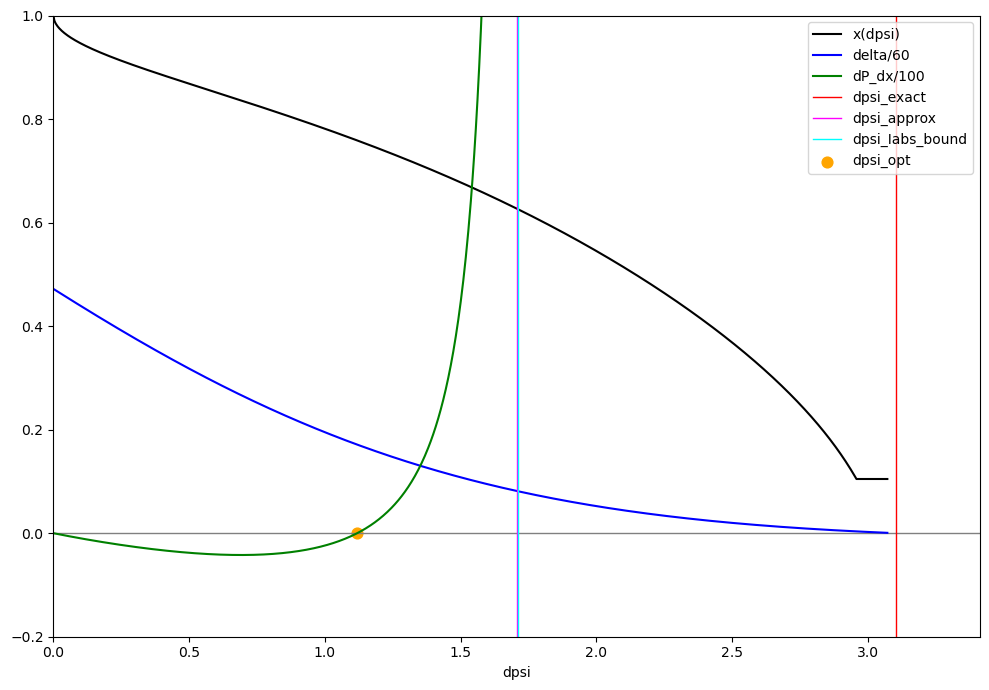

In [42]:
from default_function.calc_patm import calc_patm
from default_function.calc_kmm import calc_kmm
from default_function.calc_gammastar import calc_gammastar
from default_function.calc_ftemp_kphio import calc_ftemp_kphio
from default_function.calc_viscosity_h2o import calc_viscosity_h2o
from default_function.calc_density_h2o import calc_density_h2o

# 1. 파라미터 세팅 (R 코드의 리스트는 Python dict로)
psi_soil = -2
tc = 24.591837
ppfd = 300
vpd = 1000
co2 = 400
elv = 0
fapar = 0.7
kphio = 0.087
rdark = 0

p = calc_patm(elv)

par_photosynth_test = dict(
    kmm=calc_kmm(tc, p),
    gammastar=calc_gammastar(tc, p),
    phi0=kphio*calc_ftemp_kphio(tc),
    Iabs=ppfd*fapar,
    ca=co2*p*1e-6,   # Pa
    patm=p,
    delta=rdark
)

par_env_test = dict(
    viscosity_water=calc_viscosity_h2o(tc, p),
    density_water=calc_density_h2o(tc, p),
    patm=p,
    tc=tc,
    vpd=vpd
)

par_cost_test = dict(alpha=0.1, gamma=0.1)
par_plant_test = par_plant_proto_pm   # 이미 dict로 정의되어 있어야 함

# 2. dpsi bound
dpsi_max = calc_dpsi_bound(psi_soil, par_plant=par_plant_test, par_env=par_env_test,
                           par_photosynth=par_photosynth_test, par_cost=par_cost_test)
dpsi_exact = dpsi_max['exact']
dpsi_Iabs_bound = dpsi_max['Iabs_bound']
dpsi_approx = dpsi_max['approx_O2']

dpsi = np.linspace(0, dpsi_exact*0.99, 1000)

# 3. 변수 계산 (list comprehension 또는 numpy vectorize 사용)
x = np.array([calc_x_from_dpsi(d, psi_soil, par_plant_test, par_env_test, par_photosynth_test, par_cost_test)
              for d in dpsi])
delt = np.array([calc_delta_from_dpsi(d, psi_soil, par_plant_test, par_env_test, par_photosynth_test, par_cost_test)
                 for d in dpsi])

dPdx = [dFdx(d, psi_soil, par_photosynth_test, par_plant_test, par_env_test, par_cost_test) for d in dpsi]
dPdx_dP_dx = np.array([item['dP_dx'] if isinstance(item, dict) else item[0] for item in dPdx])

# 4. dpsi_opt 찾기 (scipy optimize root_scalar)
def dP_dx_root(dpsi_val):
    return dFdx(dpsi_val, psi_soil, par_photosynth_test, par_plant_test, par_env_test, par_cost_test)['dP_dx']

res = root_scalar(
    dP_dx_root,
    bracket=[dpsi_Iabs_bound*0.0001, dpsi_Iabs_bound*0.999],
    method='bisect'
)
dpsi_opt = res.root

# 5. 시각화 (matplotlib)
plt.figure(figsize=(10, 7))
plt.plot(dpsi, x, label="x(dpsi)", color='black')
plt.axhline(0, color="grey", lw=1)
plt.plot(dpsi, delt/60, color='blue', label="delta/60")
plt.plot(dpsi, dPdx_dP_dx/100, color='green', label="dP_dx/100")
for v, c, name in zip(
        [dpsi_exact, dpsi_approx, dpsi_Iabs_bound],
        ['red', 'magenta', 'cyan'],
        ['exact', 'approx', 'Iabs_bound']
    ):
    plt.axvline(v, color=c, lw=1, label=f'dpsi_{name}')
plt.scatter(dpsi_opt, 0, color='orange', s=60, label='dpsi_opt')

plt.ylim([-0.2, 1])
plt.xlim([0, max([dpsi_exact, dpsi_approx, dpsi_Iabs_bound])*1.1])
plt.xlabel("dpsi")
plt.legend()
plt.tight_layout()
plt.show()


검정색 선: x(dψ)

x는 χ (chi), 즉 내부 CO₂ 농도의 외부 CO₂ 농도에 대한 비율.

dψ가 커짐에 따라 기공 저항이 커지고, χ가 줄어드는 경향을 나타냄.

파란색 선: delta / 60

delta = gs' * ca * (1 - χ) - ...로 정의된 광합성의 변화율 관련 항. 모델의 목적함수에 사용됨.

수치적으로 작기 때문에 60으로 나누어 시각화됨.

초록색 선: dP_dx / 100

목표함수 F를 χ에 대해 미분한 값, 즉 ∂F/∂χ (chi 방향의 기울기).

이 값이 0이 되는 지점이 목적함수 최적점에서의 χ 조건을 만족하는 지점.

수치적으로 커서 100으로 나눠 시각화됨.

빨간 세로선: dpsi_exact

dψ에 대한 목적함수 최댓값 조건을 만족하는 정확한 이론적 upper bound.

여기까지가 모델이 고려하는 생리학적 유효 영역.

하늘색 세로선: dpsi_labs_bound

광합성이 광량(Iabs) 한계에 도달하는 지점 (Jₘₐₓ = ϕIabs)에서 계산된 upper bound.

분홍색 세로선: dpsi_approx

목적함수의 최댓값을 근사적으로 유도한 analytic solution.

주황색 점: dpsi_opt

실제 목적함수에서 ∂F/∂χ = 0 조건을 만족하도록 최적화한 실제 최적 dψ.

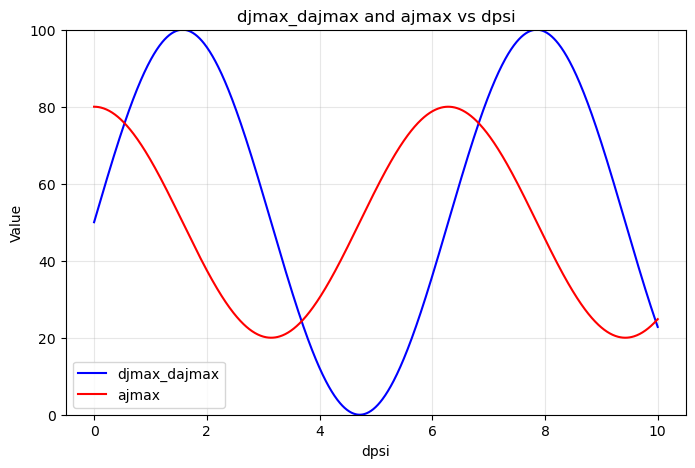

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# 예시 데이터 (dpsi, dPdx['djmax_dajmax'], dPdx['ajmax'])가 있다고 가정
# 실제 데이터로 대체하세요
dpsi = np.linspace(0, 10, 1000)
djmax_dajmax = np.sin(dpsi) * 50 + 50  # 0~100 범위로 임의 생성
ajmax = np.cos(dpsi) * 30 + 50         # 20~80 범위로 임의 생성

plt.figure(figsize=(8,5))
plt.plot(dpsi, djmax_dajmax, label='djmax_dajmax', color='blue')
plt.plot(dpsi, ajmax, label='ajmax', color='red')
plt.ylim(0, 100)
plt.xlabel('dpsi')
plt.ylabel('Value')
plt.title('djmax_dajmax and ajmax vs dpsi')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Numerical Solution
## The profit function
- Lets see the behaviour of the profit function. Does it have a maximum? How about the LC criterion?
- 이익 함수의 동작을 살펴보겠습니다. 최댓값이 있나요? LC 기준은 어떨까요?


In [44]:
import numpy as np
from scipy.optimize import minimize

def calc_vcmax_coordinated_numerical(aj, ci, par_photosynth):
    d = par_photosynth["delta"]
    numerator = aj * (ci + par_photosynth["kmm"])
    denominator = ci * (1 - d) - (par_photosynth["gammastar"] + par_photosynth["kmm"] * d)
    return numerator / denominator


def fn_profit(params, psi_soil, par_cost, par_photosynth, par_plant, par_env, opt_hypothesis, do_optim=False):
    logjmax, dpsi = params
    jmax = np.exp(logjmax)
    
    gs = hyd_transpiration.calc_gs(dpsi, psi_soil, par_plant, par_env)  # mol/m2/s/Mpa
    E = 1.6 * gs * (par_env["vpd"] / par_env["patm"]) * 1e6  # umol/m2/s

    a_j = hyd_photosynthesis.calc_assim_light_limited(gs, jmax, par_photosynth)
    a = a_j["a"]
    ci = a_j["ci"]
    vcmax = calc_vcmax_coordinated_numerical(a, ci, par_photosynth)

    costs = par_cost["alpha"] * jmax + par_cost["gamma"] * dpsi**2

    benefit = 1.0  # 상수 (원문: 1 혹은 1+(1/(ca/40.53))/2 의 평균)

    dummy_costs = 0 * np.exp(20 * (-abs(dpsi / 4) - abs(jmax / 1)))  # 안정성용

    if opt_hypothesis == "PM":
        out = a * benefit - costs - dummy_costs
    elif opt_hypothesis == "LC":
        out = -(costs + dummy_costs) / (a + 1e-4)
    else:
        raise ValueError("opt_hypothesis must be 'PM' or 'LC'")

    if do_optim:
        return -out  # minimize에서 최대화하려면 부호 반전
    else:
        return out


def optimise_midterm_multi(psi_soil, par_cost, par_photosynth, par_plant, par_env, opt_hypothesis, return_all=False):
    # 초기 추정값: logjmax=0 (jmax=1), dpsi=1
    initial_params = [0.0, 1.0]
    bounds = [(-10, 10), (1e-4, 1e6)]

    res = minimize(
        fn_profit, initial_params,
        args=(psi_soil, par_cost, par_photosynth, par_plant, par_env, opt_hypothesis, True),
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 500}
    )

    if return_all:
        return res
    else:
        return res.x  # 최적 파라미터 [logjmax, dpsi]



In [45]:
def pmodel_hydraulics_numerical(tc, ppfd, vpd, co2, elv, fapar, kphio, psi_soil, rdark=0, par_plant=None, par_cost=None, opt_hypothesis="PM"):
    p = calc_patm(elv)
    
    par_photosynth_now = {
        "kmm": calc_kmm(tc, p),
        "gammastar": calc_gammastar(tc, p),
        "phi0": kphio * calc_ftemp_kphio(tc),
        "Iabs": ppfd * fapar,
        "ca": co2 * p * 1e-6,  # Pa로 변환
        "patm": p,
        "delta": rdark
    }
    
    par_env_now = {
        "viscosity_water": calc_viscosity_h2o(tc, p),
        "density_water": calc_density_h2o(tc, p),
        "patm": p,
        "tc": tc,
        "vpd": vpd
    }
    
    par_plant_now = par_plant
    
    if par_cost is not None:
        par_cost_now = par_cost
    else:
        if opt_hypothesis == "PM":
            par_cost_now = {
                "alpha": 0.1,
                "gamma": 1.0
            }
        elif opt_hypothesis == "LC":
            par_cost_now = {
                "alpha": 0.1,
                "gamma": 0.5
            }
        else:
            raise ValueError("opt_hypothesis must be 'PM' or 'LC'")
    
    # 최적화 수행 (최적 jmax와 dpsi 구하기)
    lj_dps = optimise_midterm_multi(
        fn_profit,
        psi_soil=psi_soil,
        par_cost=par_cost_now,
        par_photosynth=par_photosynth_now,
        par_plant=par_plant_now,
        par_env=par_env_now,
        opt_hypothesis=opt_hypothesis
    )
    
    profit = fn_profit(
        lj_dps,
        psi_soil=psi_soil,
        par_cost=par_cost_now,
        par_photosynth=par_photosynth_now,
        par_plant=par_plant_now,
        par_env=par_env_now,
        opt_hypothesis=opt_hypothesis
    )
    
    jmax = np.exp(lj_dps[0])
    dpsi = lj_dps[1]
    
    gs = hyd_transpiration.calc_gs(dpsi=dpsi, psi_soil=psi_soil, par_plant=par_plant_now, par_env=par_env_now)
    
    a_j = hyd_photosynthesis.calc_assim_light_limited(gs=gs, jmax=jmax, par_photosynth=par_photosynth_now)
    a = a_j["a"]
    ci = a_j["ci"]
    
    vcmax = calc_vcmax_coordinated_numerical(a, ci, par_photosynth_now)
    
    chi = ci / par_photosynth_now["ca"]
    
    return {
        "jmax": jmax,
        "dpsi": dpsi,
        "gs": gs,
        "a": a,
        "ci": ci,
        "chi": chi,
        "vcmax": vcmax,
        "profit": profit,
        "chi_jmax_lim": 0  # 필요하면 계산해서 대체 가능
    }


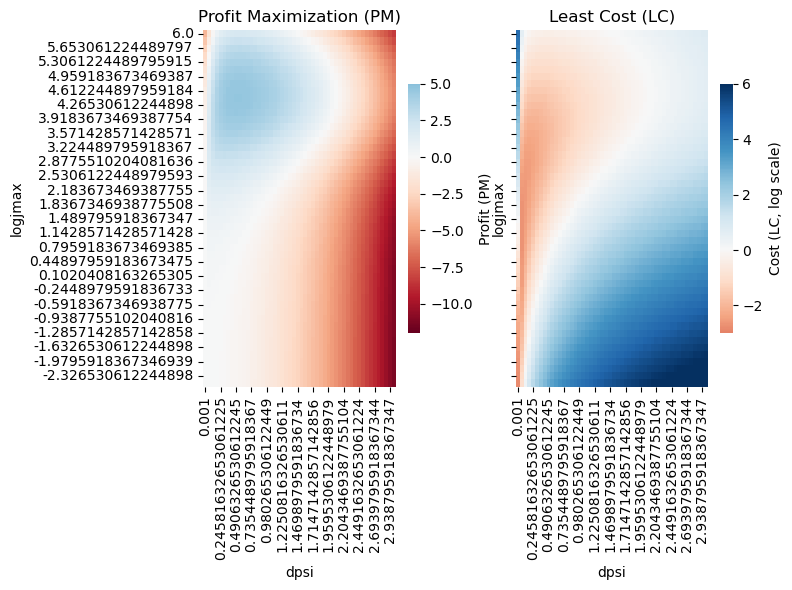

In [46]:
import seaborn as sns
from itertools import product

# --- (1) 파라미터 설정 ---
psi_soil = 0
par_cost_pm = {"alpha": 0.01, "gamma": 5/4}
par_cost_lc = {"alpha": 0.01, "gamma": 5/4}
par_photosynth_std = par_photosynth  # 위에서 사용되던거 그대로 사용
par_plant_std = par_plant_proto_pm                    # 미리 정의된 plant params
par_env_std = par_env_test                            # 미리 정의된 env params

# --- (2) dpsi와 logjmax grid 생성 ---
dpsi_vals = np.linspace(0.001, 3, 50)
logjmax_vals = np.linspace(-2.5, 6, 50)

# --- (3) 격자 데이터프레임 생성 ---

grid = pd.DataFrame(list(product(dpsi_vals, logjmax_vals)), columns=['dpsi', 'logjmax'])

# --- (4) profit 계산 함수 매핑 ---

def calc_profit_pm(row):
    par = [row['logjmax'], row['dpsi']]
    return fn_profit(par, psi_soil=psi_soil, par_cost=par_cost_pm, par_photosynth=par_photosynth_std, par_plant=par_plant_std, par_env=par_env_std, do_optim=False, opt_hypothesis="PM")

def calc_profit_lc(row):
    par = [row['logjmax'], row['dpsi']]
    return fn_profit(par, psi_soil=psi_soil, par_cost=par_cost_lc, par_photosynth=par_photosynth_std, par_plant=par_plant_std, par_env=par_env_std, do_optim=False, opt_hypothesis="LC")

grid['profit_pm'] = grid.apply(calc_profit_pm, axis=1)
grid['profit_lc'] = grid.apply(calc_profit_lc, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(8, 6), sharex=True, sharey=True)  # 가로 길이 짧게 조정

# PM plot
pm_pivot = grid.pivot(index='logjmax', columns='dpsi', values='profit_pm')
pm_pivot_rev = pm_pivot.iloc[::-1]  # y축 뒤집기용

sns.heatmap(
    pm_pivot_rev,
    ax=axes[0],
    cmap='RdBu',          
    cbar_kws={'label': 'Profit (PM)', 'shrink': 0.7},
    center=0,
    vmin=-12, vmax=5
)
axes[0].set_title('Profit Maximization (PM)')
axes[0].set_xlabel('dpsi')
axes[0].set_ylabel('logjmax')

# LC plot
with np.errstate(divide='ignore', invalid='ignore'):
    cost_lc = np.log(1e-6 - grid['profit_lc'])
cost_lc = cost_lc.replace([np.inf, -np.inf], np.nan).fillna(-3)

lc_pivot = pd.DataFrame({
    'dpsi': grid['dpsi'],
    'logjmax': grid['logjmax'],
    'cost_lc': cost_lc
}).pivot(index='logjmax', columns='dpsi', values='cost_lc')
lc_pivot_rev = lc_pivot.iloc[::-1]  # y축 뒤집기용

sns.heatmap(
    lc_pivot_rev,
    ax=axes[1],
    cmap='RdBu',             
    cbar_kws={'label': 'Cost (LC, log scale)', 'shrink': 0.7},
    center=0,
    vmin=-3, vmax=6
)
axes[1].set_title('Least Cost (LC)')
axes[1].set_xlabel('dpsi')
axes[1].set_ylabel('logjmax')

plt.tight_layout()
plt.show()



네, PM 가설에서는 ΔΨ≈1이라는 매우 현실적인 값을 사용합니다.
하지만 LC 가설에서는 그렇지 않습니다. 최소값은 0에서 발생합니다!

따라서 PM 가설(Profit Maximization 가설) 하에서는, 최적 이익이 발생하는 지점에서 ΔΨ (델타 싸이, 즉 잎과 토양 사이의 수분 포텐셜 차이)가 약 1 정도로 현실적인 값을 가지므로, 즉, 식물이 수분 스트레스와 광합성 효율 사이에서 균형을 잡아 최적 상태를 이루지만 반면에 LC 가설(Least Cost, 최소 비용 가설) 하에서는, 최적점이 ΔΨ = 0에서 발생한다. 즉, 비용 측면에서 보면 잎과 토양 사이 수분 포텐셜 차이를 만들지 않는 것이 최소 비용이라는 뜻이다.

LC 모델은 비용만을 고려했을 때는 ΔΨ가 0으로 최소화되어, 수분 스트레스 없이 유지하려고 한다고 해석된다.
따라서 이 문장은 두 최적화 가설이 수분 상태에 대해 서로 다른 최적 해를 제시하며, PM 가설이 더 실제 관찰에 부합할 가능성이 있음을 시사함








## Some utilities to facilitate comparison with classic pmodel (Wang et al 2017)
We must convert outputs of the classic model into units that the hydraulic pmodel outputs:

In [47]:
import default_function.rpmodel as rpmodel

def pmodel_wang17(tc, ppfd, vpd, co2, elv, fapar, kphio, **kwargs):
    """
    P-model as per Wang et al 2017
    This needs PPFD in mol/m2/day
    """

    out_analytical = rpmodel.rpmodel(
        tc=tc,
        vpd=vpd,
        co2=co2,
        elv=elv,
        kphio=kphio,
        beta=146,
        fapar=fapar,
        ppfd=ppfd * 1e-6 * 86400,  # p-model requires in mol/m2/day
        **kwargs
    )
    # Convert some outputs to facilitate comparison
    patm = calc_patm(elv)
    
    # 단위 변환
    out_analytical_converted = out_analytical.copy()
    out_analytical_converted.update({
        'gs': out_analytical['gs'] / 86400 * patm,  # mol/m2/day/Pa --> mol/m2/s
        'gpp': out_analytical['gpp'] / 1.03772448,  # gC/m2/day --> umol/m2/s
        'vcmax': out_analytical['vcmax'] / 0.0864,  # mol/m2/day --> umol/m2/s
        'jmax': out_analytical['jmax'] / 0.0864     # mol/m2/day --> umol/m2/s
    })
    
    return out_analytical_converted

def pmodel_calibrate(tc, ppfd, vpd, co2, elv, fapar, kphio, psi_soil, rdark=0, par_plant=None, par_cost=None, opt_hypothesis="PM"):
    """
    Combine Hydraulic and classic results
    """
    out_hydraulics = pmodel_hydraulics_analytical(
        tc, ppfd, vpd, co2, elv, fapar, kphio, psi_soil, rdark, par_plant, par_cost
    )
    
    out_analytical = pmodel_wang17(tc, ppfd, vpd, co2, elv, fapar, kphio)
    
    return {
        'out_hydraulics': out_hydraulics,
        'out_analytical': out_analytical
    }

def pmodel_calibrate_numerical(tc, ppfd, vpd, co2, elv, fapar, kphio, psi_soil, rdark=0, par_plant=None, par_cost=None, opt_hypothesis="PM"):
    """
    Numerical version of pmodel_calibrate
    """
    out_hydraulics = pmodel_hydraulics_numerical(
        tc, ppfd, vpd, co2, elv, fapar, kphio, psi_soil, rdark, par_plant, par_cost, opt_hypothesis
    )
    
    out_analytical = pmodel_wang17(tc, ppfd, vpd, co2, elv, fapar, kphio)
    
    return {
        'out_hydraulics': out_hydraulics,
        'out_analytical': out_analytical
    }
    

## Soil moisture response
### Acclimated response
Here is a comparison of the hydraulic P-model (line - analytical, points - numerical) with the classic P-model (grey):

In [48]:
import numpy as np
import pandas as pd
from default_function.calc_patm import calc_patm
from default_function.calc_kmm import calc_kmm  
from default_function.calc_gammastar import calc_gammastar
from default_function.calc_ftemp_kphio import calc_ftemp_kphio
from default_function.calc_viscosity_h2o import calc_viscosity_h2o
from default_function.calc_density_h2o import calc_density_h2o
# Create empty list (equivalent to l = list())
l = []

# Create the var sequence (-6 to 0 with 50 points)
var_values = np.linspace(-6, 0, 50)

# Define parameters (from the notebook)
par_plant_proto_pm = {
    "conductivity": 3e-17,   # leaf specific conductivity (m2)
    "psi50": -2,             # Vulnerability curve (MPa)
    "b": 2                   # Curve shape parameter
}

par_cost = {"alpha": 0.1, "gamma": 0.1}

# Apply pmodel_calibrate to each var value and collect results
results = []
error_count = 0

for i, var in enumerate(var_values):
    try:
        out = pmodel_calibrate(
            tc=25,
            ppfd=300,
            vpd=1000,
            co2=400,
            elv=0,
            fapar=0.7,
            kphio=0.087,
            psi_soil=var,  # This is the key: psi_soil = var
            rdark=0.02,
            par_plant=par_plant_proto_pm,
            par_cost=par_cost
        )
        
        # Flatten the nested structure (equivalent to unnest_wider)
        row_data = {"var": var}
        
        # Add hydraulics results with "out_hydraulics_" prefix
        for k, v in out["out_hydraulics"].items():
            row_data[f"out_hydraulics_{k}"] = v
            
        # Add analytical results with "out_analytical_" prefix  
        for k, v in out["out_analytical"].items():
            row_data[f"out_analytical_{k}"] = v
            
        results.append(row_data)
        
        # 진행상황 출력 (매 10번째마다)
        if (i + 1) % 10 == 0:
            print(f"진행: {i + 1}/{len(var_values)} 완료")
        
    except Exception as e:
        error_count += 1
        print(f"Error for psi_soil={var}: {e}")
        # 에러가 발생해도 NaN으로 채워서 계속 진행하려면:
        # row_data = {"var": var}
        # for key in expected_columns:  # 예상되는 컬럼들
        #     row_data[key] = np.nan
        # results.append(row_data)

# 결과 확인
print(f"\n총 처리: {len(var_values)}개")
print(f"성공: {len(results)}개")
print(f"실패: {error_count}개")

# Convert to DataFrame (equivalent to tibble)
if len(results) > 0:
    dat_soilm = pd.DataFrame(results)
    
    # Display the results
    print(f"\ndat_soilm 생성 성공!")
    print(f"Shape: {dat_soilm.shape}")
    print(f"Columns: {list(dat_soilm.columns)}")
    print("\n처음 5행:")
    print(dat_soilm.head())
    
    # 시각화를 위해 필요한 컬럼들이 있는지 확인
    required_cols = ['var', 'out_hydraulics_dpsi', 'out_hydraulics_dpsi_max_exact', 
                     'out_hydraulics_dpsi_max_approx', 'out_hydraulics_dpsi_max_Iabs_bound']
    missing_cols = [col for col in required_cols if col not in dat_soilm.columns]
    
    if missing_cols:
        print(f"\n경고: 시각화에 필요한 컬럼이 없습니다: {missing_cols}")
    else:
        print("\n✓ 시각화에 필요한 모든 컬럼이 있습니다!")
        
else:
    print("결과가 없어서 데이터프레임을 생성할 수 없습니다.")
    dat_soilm = pd.DataFrame()  # 빈 데이터프레임 생성

진행: 10/50 완료
진행: 20/50 완료
진행: 30/50 완료
진행: 40/50 완료
진행: 50/50 완료

총 처리: 50개
성공: 50개
실패: 0개

dat_soilm 생성 성공!
Shape: (50, 32)
Columns: ['var', 'out_hydraulics_jmax', 'out_hydraulics_dpsi', 'out_hydraulics_gs', 'out_hydraulics_a', 'out_hydraulics_ci', 'out_hydraulics_chi', 'out_hydraulics_chi_jmax_lim', 'out_hydraulics_vcmax', 'out_hydraulics_profit', 'out_hydraulics_niter', 'out_hydraulics_nfcnt', 'out_hydraulics_dpsi_max_exact', 'out_hydraulics_dpsi_max_approx', 'out_hydraulics_dpsi_max_Iabs_bound', 'out_analytical_ca', 'out_analytical_gammastar', 'out_analytical_kmm', 'out_analytical_ns_star', 'out_analytical_chi', 'out_analytical_mj', 'out_analytical_mc', 'out_analytical_ci', 'out_analytical_lue', 'out_analytical_gpp', 'out_analytical_iwue', 'out_analytical_gs', 'out_analytical_vcmax', 'out_analytical_vcmax25', 'out_analytical_jmax', 'out_analytical_jmax25', 'out_analytical_rd']

처음 5행:
        var  out_hydraulics_jmax  out_hydraulics_dpsi  out_hydraulics_gs  \
0 -6.000000           

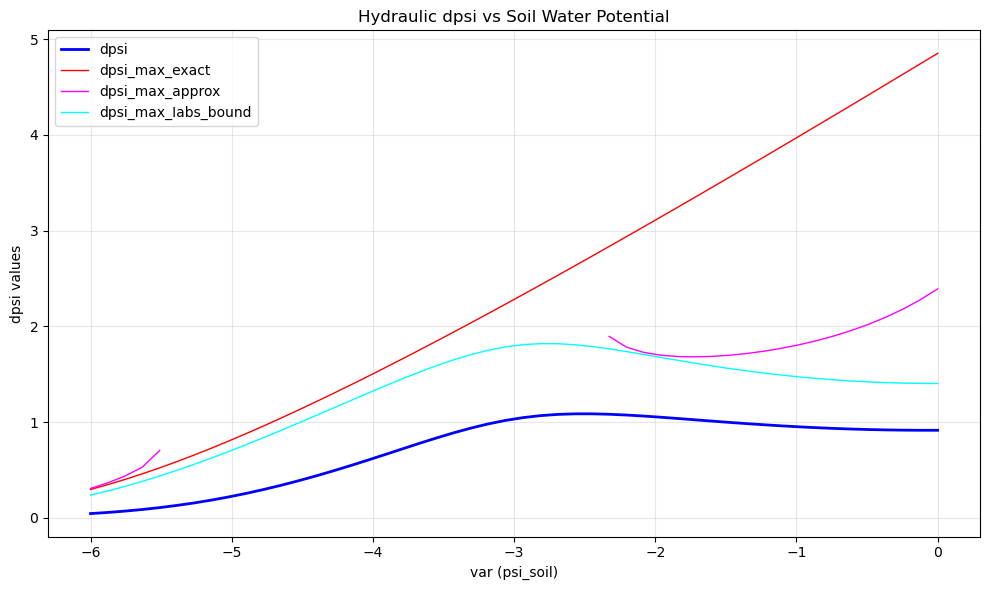

In [49]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(10, 6))

# 4개의 선 그리기
plt.plot(dat_soilm['var'], dat_soilm['out_hydraulics_dpsi'], 
         color='blue', linewidth=2, label='dpsi')
plt.plot(dat_soilm['var'], dat_soilm['out_hydraulics_dpsi_max_exact'], 
         color='red', linewidth=1, label='dpsi_max_exact')
plt.plot(dat_soilm['var'], dat_soilm['out_hydraulics_dpsi_max_approx'], 
         color='magenta', linewidth=1, label='dpsi_max_approx')
plt.plot(dat_soilm['var'], dat_soilm['out_hydraulics_dpsi_max_Iabs_bound'], 
         color='cyan', linewidth=1, label='dpsi_max_Iabs_bound')

plt.xlabel('var (psi_soil)')
plt.ylabel('dpsi values')
plt.title('Hydraulic dpsi vs Soil Water Potential')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/s0/6fg4kkm534vgnh5rxk70ljkc0000gn/T/ipykernel_31764/1650470630.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


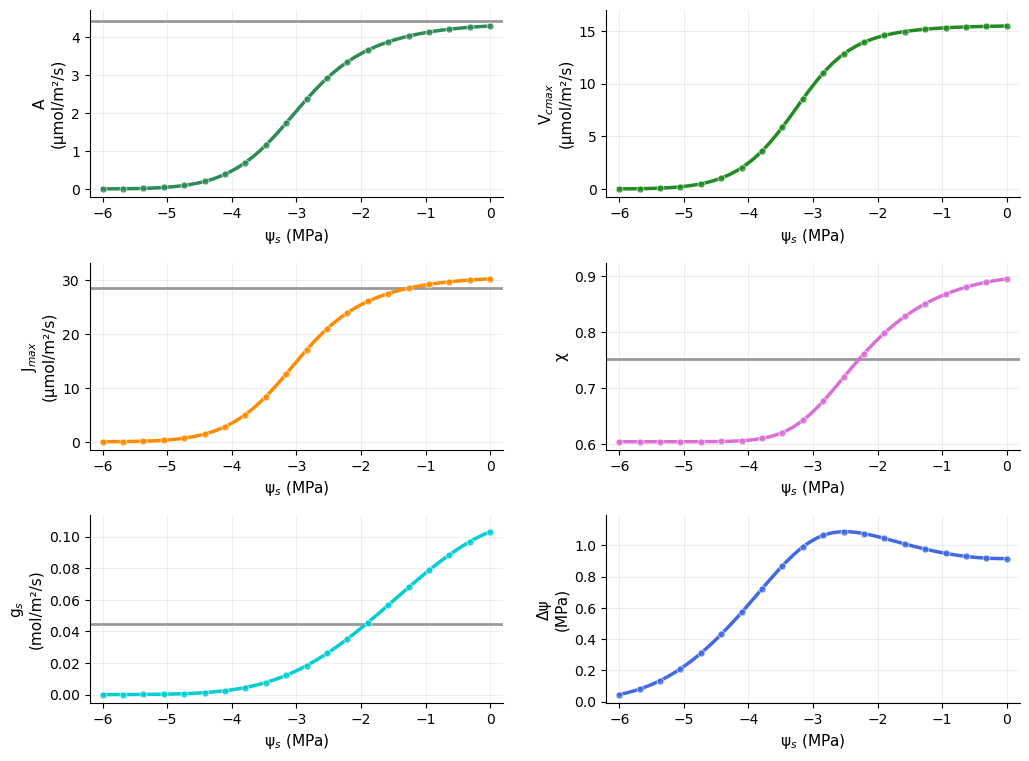

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def create_comparison_plots(dat_analytical, dat_approximation=None, dat_wang=None):
    
    # 변수 정의: (hydraulic_col, wang_col, ylabel, color, title)
    variables = [
        ('out_hydraulics_a', 'out_analytical_gpp', 'A\n(μmol/m²/s)', '#2E8B57', 'A'),
        ('out_hydraulics_vcmax', 'out_analytical_vcmax', 'V$_{cmax}$\n(μmol/m²/s)', '#228B22', 'Vcmax'),
        ('out_hydraulics_jmax', 'out_analytical_jmax', 'J$_{max}$\n(μmol/m²/s)', '#FF8C00', 'Jmax'),
        ('out_hydraulics_chi', 'out_analytical_chi', 'χ', '#DA70D6', 'χ'),
        ('out_hydraulics_gs', 'out_analytical_gs', 'g$_s$\n(mol/m²/s)', '#00CED1', 'gs'),
        ('out_hydraulics_dpsi', None, 'Δψ\n(MPa)', '#4169E1', 'Δψ')
    ]
    
    # Figure 설정
    fig = plt.figure(figsize=(12, 9))
    gs = GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.25)
    
    for i, (hyd_col, wang_col, ylabel, color, title) in enumerate(variables):
        ax = fig.add_subplot(gs[i//2, i%2])
        
        # 1. Hydraulic analytical (컬러 실선)
        if hyd_col in dat_analytical.columns:
            ax.plot(dat_analytical['var'], dat_analytical[hyd_col], 
                   color=color, linewidth=2.5, zorder=3)
        
        # 2. Hydraulic approximation (같은 색 점들)
        if dat_approximation is not None and hyd_col in dat_approximation.columns:
            ax.scatter(dat_approximation['var'], dat_approximation[hyd_col], 
                      color=color, s=25, alpha=0.8, zorder=4, edgecolors='white', linewidth=0.5)
        
        # 3. 원래 Wang 모델 (회색 수평선)
        if dat_wang is not None and wang_col is not None and wang_col in dat_wang.columns:
            wang_value = dat_wang[wang_col].iloc[0]
            ax.axhline(y=wang_value, color='#808080', linewidth=2, 
                      linestyle='-', alpha=0.8, zorder=1)
        
        # 축 설정
        ax.set_xlabel('ψ$_s$ (MPa)', fontsize=11)
        ax.set_ylabel(ylabel, fontsize=11)
        ax.grid(True, alpha=0.3, linewidth=0.5)
        
        # 축 범위 설정
        ax.set_xlim(-6.2, 0.2)
        
        # y축 범위를 데이터에 맞게 조정
        if hyd_col in dat_analytical.columns:
            y_data = dat_analytical[hyd_col]
            y_min, y_max = y_data.min(), y_data.max()
            y_range = y_max - y_min
            ax.set_ylim(y_min - 0.05*y_range, y_max + 0.1*y_range)
        
        # 스타일 조정
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.8)
        ax.spines['bottom'].set_linewidth(0.8)
    
    plt.tight_layout()
    plt.show()




if 'dat_soilm' in globals() and len(dat_soilm) > 0:
    # dat_wang_original이 없으면 생성
    if 'dat_wang_original' not in globals():
        print("Wang 모델 데이터 생성 중...")
        wang_results = []
        for var in np.linspace(-6, 0, 10):  # 적은 수로도 충분 (수평선이므로)
            try:
                out_wang = pmodel_wang17(
                    tc=25, ppfd=300, vpd=1000, co2=400, elv=0, 
                    fapar=0.7, kphio=0.087
                )
                row_data = {"var": var}
                for k, v in out_wang.items():
                    row_data[f"out_analytical_{k}"] = v
                wang_results.append(row_data)
            except Exception as e:
                print(f"Wang model error: {e}")
                break
        
        dat_wang_original = pd.DataFrame(wang_results)
    
    # dat_soilm_numerical이 없으면 생성 (approximation 방법)
    if 'dat_soilm_numerical' not in globals() or len(dat_soilm_numerical) == 0:
        print("Approximation 데이터 생성 중...")
        var_values_num = np.linspace(-6, 0, 20)
        results_num = []
        
        for var in var_values_num:
            try:
                out_hyd = pmodel_hydraulics_analytical(
                    tc=25, ppfd=300, vpd=1000, co2=400, elv=0, 
                    fapar=0.7, kphio=0.087, psi_soil=var, rdark=0.02,
                    par_plant=par_plant_proto_pm, par_cost=par_cost
                )
                row_data = {"var": var}
                for k, v in out_hyd.items():
                    row_data[f"out_hydraulics_{k}"] = v
                results_num.append(row_data)
            except:
                continue
        
        dat_soilm_numerical = pd.DataFrame(results_num)
    
    create_comparison_plots(
        dat_analytical=dat_soilm,
        dat_approximation=dat_soilm_numerical if len(dat_soilm_numerical) > 0 else None,
        dat_wang=dat_wang_original if len(dat_wang_original) > 0 else None
    )
      
else:
    print("✗ dat_soilm 데이터가 필요합니다.")